# Importance Sampling

### Monte Carlo Integration example

We consider the 1D probability density function of a normal distribution
    $$f_X(t) = \frac{e^{-t^2/2}}{\sqrt{2 \pi}}.$$
The probability to get a random draw that is greater than 3 from the normal distribution is given by the integral
    $$\int_3^\infty f_X(t)\,dt = \frac{1}{\sqrt{2 \pi}} \int_3^\infty e^{-t^2/2}\,dt \tag{1}$$
Let us define a function 
    $$h(t) = \begin{cases}
       1, & t > 3\\
       0, & t \leq 3.
    \end{cases}$$
So we can rewrite (1) as follows,
    $$\int_3^\infty f_X(t)\,dt = \int_{-\infty}^\infty h(t)f_X(t)\,dt.$$
We can then estimate the probability using Monte Carlo integration.
    $$\int_{-\infty}^\infty h(t)f_X(t)\,dt \approx \frac1N \sum_{i=1}^{N} h(x_i) $$
 

In [1]:
%matplotlib notebook

from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [2]:
F = stats.norm() #loc=3, scale=2,  loc == mean, scale == std dev

<IPython.core.display.Javascript object>


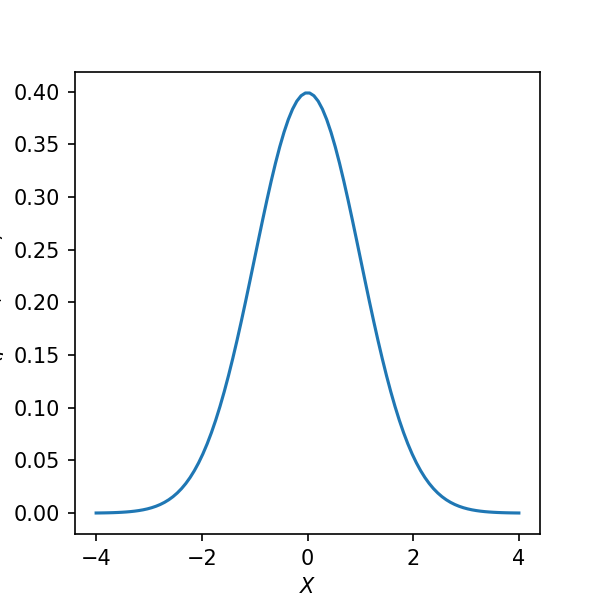

In [3]:
X = np.linspace(-4,4,100)

plt.figure(figsize=(4,4))
plt.plot(X, F.pdf(X))
plt.xlabel(r"$X$")
plt.ylabel(r"$F(\mu = 0, \sigma=1)$")
plt.show()

In [4]:
def h(t):
    if t > 3:
        return 1
    
    else:
        return 0
    
def prob1(N):
    # Defines the normal distribution, mean = 0, std = 1
    F = stats.norm()
    
    # Draws numbers at random from the normal distribution
    x = F.rvs(N)
    
    # Estimates the integral
    P = 0
    for x_i in x:
        P += h(x_i)
        
    return P / N 

In [5]:
prob1(100000000) #probability of drawing greater than 3

0.0013515

# Advantages of Importance Sampling

If draws in the region of interest is unlikely, then it is possible that we can't get random draws within the region of interest. The Monte Carlo integration would then require a very large number of sample points just to get evaluate the integral.

Importance sampling makes Monte Carlo integration more efficient in circumstances where random draws within the region of interest is unlikely. In Monte Carlo integration, random points that are close to and within the bounds of integration are more likely to influence the approximation than points that are farther away. These points are called **important points**. 

In importance sampling, we call the distribution of the integral we want to estimate the **target distribution**, and we denote it $f_X$. The idea of importance sampling is to choose a new distribution, called the **importance distribution**, that *generates more important points*. The importance distribution is usually denoted $g_Y$. Below is a modified Monte Carlo integration:
    $$\int_{-\infty}^\infty h(t)f_X(t)\,dt \approx \frac1N \sum_{i=1}^{N} \frac{h(y_i) f_X(y_i)}{g_Y(y_i)}$$
The fraction $\frac{h(y_i)}{g_Y(y_i)}$ is called the **importance weight**. We can then use samples $y_1, \ldots, y_N$ from *any* distribution with equation $g_Y$ to estimate the integral of $f_X$. If $g_Y = f_X$ then the importance weight is just $1$. The problem then reduces to solving the original Monte Carlo integration approximation.

In the previous example, we can choose $g_Y$ to be a normal distribution with $\mu = 4$ and $\sigma = 1$.

In [6]:
def prob2(f, g, h, N):
    '''
    Parameters:
        f = target distribution
        g = importance distribution
        h = indicator function
        N = number of random samples to use
    '''
    # Get random samples from the importance distribution
    Y = g.rvs(N)
    
    # Estimate the integral
    P = 0
    for y_i in Y:
        P += h(y_i) * f.pdf(y_i) / g.pdf(y_i)
        
    return P / N

In [7]:
N = 10000
f = stats.norm()
g = stats.norm(loc=4, scale=1)

def h(t):
    if t > 3:
        return 1
    
    else:
        return 0
    
prob2(f, g, h, N)

0.0013204572344912707

Fewer samples are needed to obtain an accurate value. There is no correct choice for $g_Y$ but there are choices that are better than others. A bad choice of $g_Y$ would mean that the vanilla Monte Carlo integration performs better than importance sampling.

# Comparison with vanilla Monte Carlo Integration

In [8]:
N_ls = np.logspace(0, 6.0, 20, endpoint=True, dtype=int) #[5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 250000, 500000]


def h(t):
    if t > 3:
        return 1
    
    else:
        return 0
    
f = stats.norm()
g = stats.norm(loc=4, scale=1)
    
monte_carlo_results = []
importance_sampling_results = []

for N in N_ls:
    print(N)
    monte_carlo_results.append(prob1(N))
    importance_sampling_results.append(prob2(f, g, h, N))

1
2
4
8
18
37
78
162
335
695
1438
2976
6158
12742
26366
54555
112883
233572
483293
1000000


In [9]:
true_value = 0.0013498980316301035
monte_carlo_error = [abs(i - true_value) for i in monte_carlo_results]
importance_sampling_error = [abs(i - true_value) for i in importance_sampling_results]

<IPython.core.display.Javascript object>


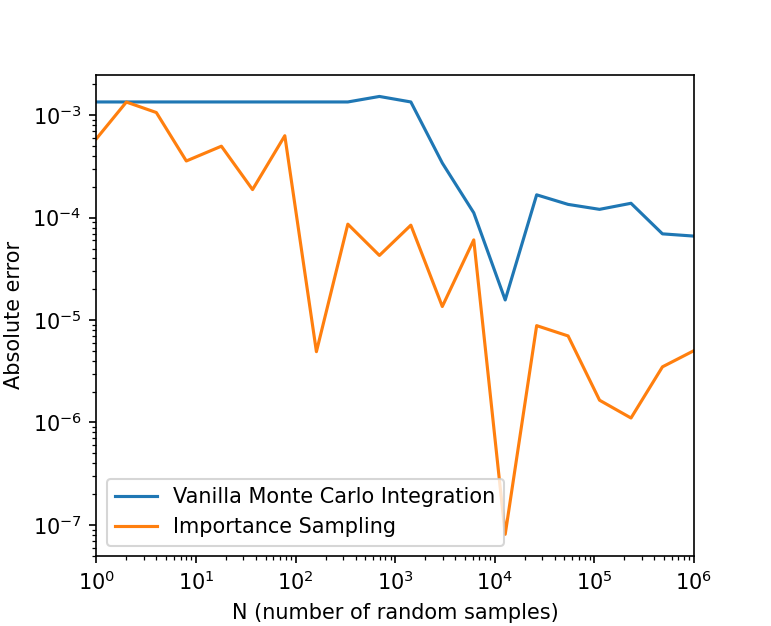

In [10]:
plt.figure(figsize=(4,4))

plt.loglog(N_ls, monte_carlo_error, label="Vanilla Monte Carlo Integration")
plt.loglog(N_ls, importance_sampling_error, label="Importance Sampling")

plt.xlim(1e0,1e6)
plt.xlabel("N (number of random samples)")
plt.ylabel("Absolute error")
plt.legend()

With a good choice of $g_Y$, the importance sampling method converges faster with fewer $N$.

# Bad choice of $g_Y$

There are choices of $g_Y$ that do not give better results than the Monte Carlo method. In our previous problems we chose a normal distribution with $\mu=0, \sigma=1$, which results to giving more important points. However, if we chose, say for example $\mu=0, \sigma=.5$, the approximation using importance sampling would be worse.

In [11]:
N_ls = np.logspace(0, 5.0, 20, endpoint=True, dtype=int) #[5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000, 250000, 500000]

def h(t):
    if t > 3:
        return 1
    
    else:
        return 0
    
f = stats.norm()
g_Y1 = stats.norm(loc=-1, scale=1)
g_Y2 = stats.norm(loc=0.25, scale=1)
g_Y3 = stats.norm(loc=4, scale=1)
g_Y4 = stats.norm(loc=7, scale=1)
    
monte_carlo_results = []
g_Y1_results = []
g_Y2_results = []
g_Y3_results = []
g_Y4_results = []

for N in N_ls:
    print(N)
    monte_carlo_results.append(prob1(N))
    g_Y1_results.append(prob2(f, g_Y1, h, N))
    g_Y2_results.append(prob2(f, g_Y2, h, N))
    g_Y3_results.append(prob2(f, g_Y3, h, N))
    g_Y4_results.append(prob2(f, g_Y4, h, N))

1
1
3
6
11
20
37
69
127
233
428
784
1438
2636
4832
8858
16237
29763
54555
100000


In [12]:
true_value = 0.0013498980316301035
monte_carlo_error = [abs(i - true_value) for i in monte_carlo_results]
importance_sampling1_error = [abs(i - true_value) for i in g_Y1_results]
importance_sampling2_error = [abs(i - true_value) for i in g_Y2_results]
importance_sampling3_error = [abs(i - true_value) for i in g_Y3_results]
importance_sampling4_error = [abs(i - true_value) for i in g_Y4_results]

<IPython.core.display.Javascript object>


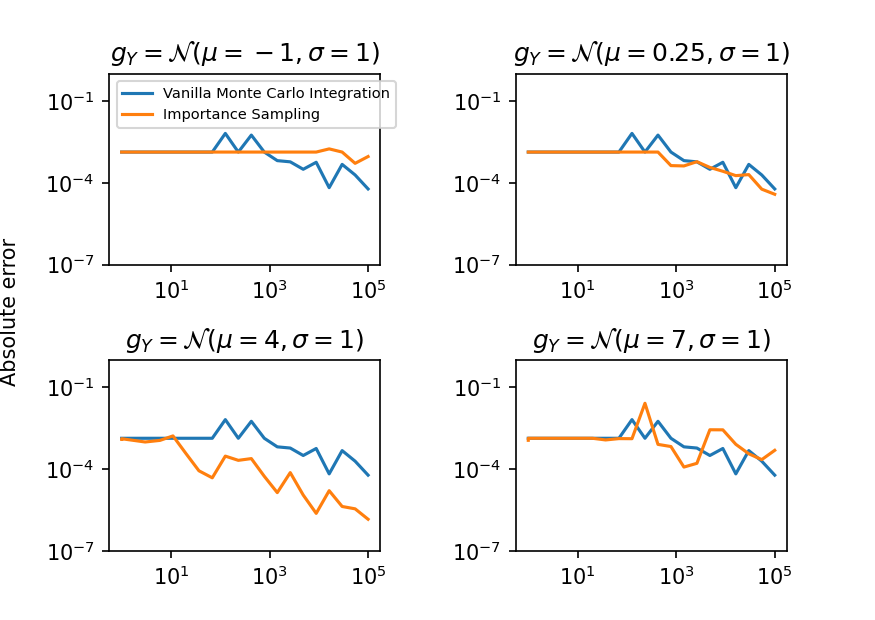

In [21]:
fig = plt.figure()

# Big subplot
ax = fig.add_subplot(111)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
ax.set_xlabel("Number of samples", labelpad=20)
ax.set_ylabel("Absolute error", labelpad=20)

# Subplots
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)


ax1.loglog(N_ls, monte_carlo_error, label="Vanilla Monte Carlo Integration")
ax1.loglog(N_ls, importance_sampling1_error, label="Importance Sampling")
ax1.set_ylim(1e-7, 1e0)
ax1.set_title(r"$g_Y = \mathcal{N}(\mu = -1, \sigma =1)$")
ax1.legend(loc=2, fontsize=7)

ax2.loglog(N_ls, monte_carlo_error)
ax2.loglog(N_ls, importance_sampling2_error)
ax2.set_ylim(1e-7, 1e0)
ax2.set_title(r"$g_Y = \mathcal{N}(\mu = 0.25, \sigma =1)$")



ax3.loglog(N_ls, monte_carlo_error)
ax3.loglog(N_ls, importance_sampling3_error)
ax3.set_title(r"$g_Y = \mathcal{N}(\mu = 4, \sigma =1)$")
ax3.set_ylim(1e-7, 1e0)


ax4.loglog(N_ls, monte_carlo_error)
ax4.loglog(N_ls, importance_sampling4_error)
ax4.set_title(r"$g_Y = \mathcal{N}(\mu = 7, \sigma =1)$")
ax4.set_ylim(1e-7, 1e0)

fig.subplots_adjust(wspace=.5, hspace=.5)

Importance sampling performs better than vanilla Monte Carlo integration only the third plot (bottom-left) due to the presence of more important points near the region of interest.

# Gamma distribution

The Gamma distribution is given by
    $$f_X(x) = \frac{x^{a-1} e^{-x/10}}{\Gamma(a) \theta^a}.$$ <br/>
It is usually used to model waiting times.

Suppose we are working at a tech support line, which receives an average of 2 calls per minute. What is the probability that we have to wait at least 10 minutes to receive 9 calls? This problem can be modeled using the gamma distribution. The variables are 

* $x$ = number of minutes needed to wait to receive $a$ calls given $\theta$ calls per minute.
* $\theta$ = the number of minutes it takes on average to receive one call.
* $a$ = number of calls we are waiting to receive.
* $\Gamma$ = the Gamma function.

In this problem, 
* $a = 9$
* $\theta = \frac12$

### Manually

In [49]:
from scipy.special import gamma as gamma_fxn

def gamma_distribution(x, a, theta):
    '''
    x = an array of points
    a = 
    '''
    return (x**(a - 1) * np.exp(- x / theta)) / (gamma_fxn(a) * (theta**(a))) # returns an array of probabilities

def normal_distribution(x, mu, sigma):
    return (1/ (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu)/2)**2 / 2)

### Scipy

<IPython.core.display.Javascript object>


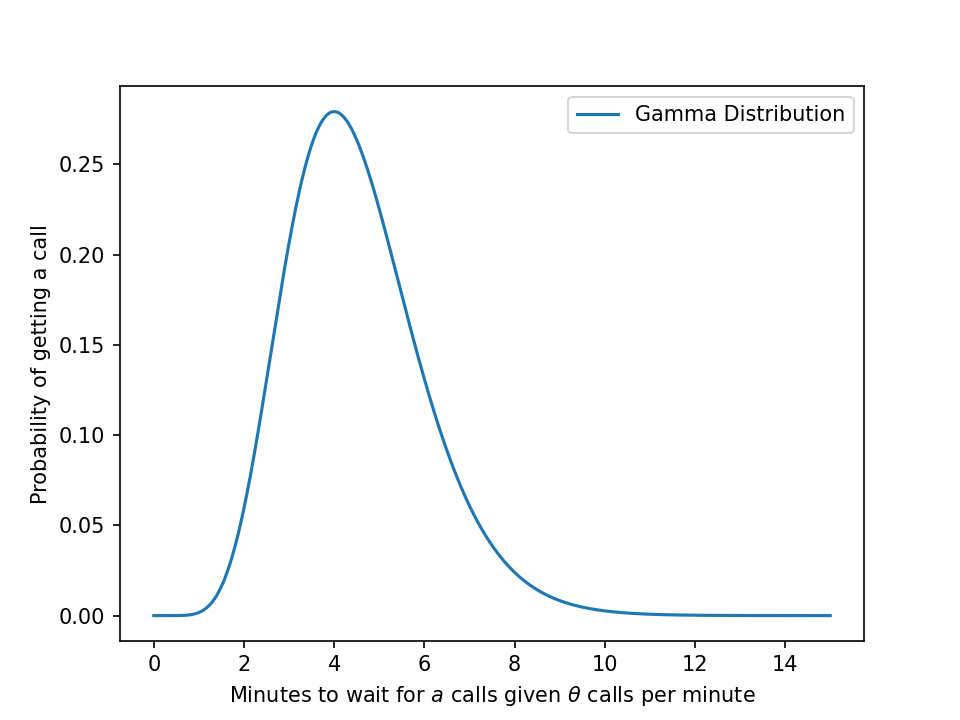

In [29]:
F = stats.gamma(a=9, scale=.5) # scale == theta
X = np.linspace(0,15,1000)
plt.figure()
plt.plot(X, F.pdf(X), label="Gamma Distribution")
plt.xlabel(r"Minutes to wait for $a$ calls given $\theta$ calls per minute")
plt.ylabel("Probability of getting a call")
plt.legend()

To answer the problem we need to evaluate
    $$\int_{10}^{\infty}h(x)f_X(x)\,dx$$
using importance sampling, where 
    $$h(t) = \begin{cases}
       1, & t > 10\\
       0, & t \leq 10.
    \end{cases}$$
We can choose a normal distribution as $g_Y$ to produce important points.

<IPython.core.display.Javascript object>


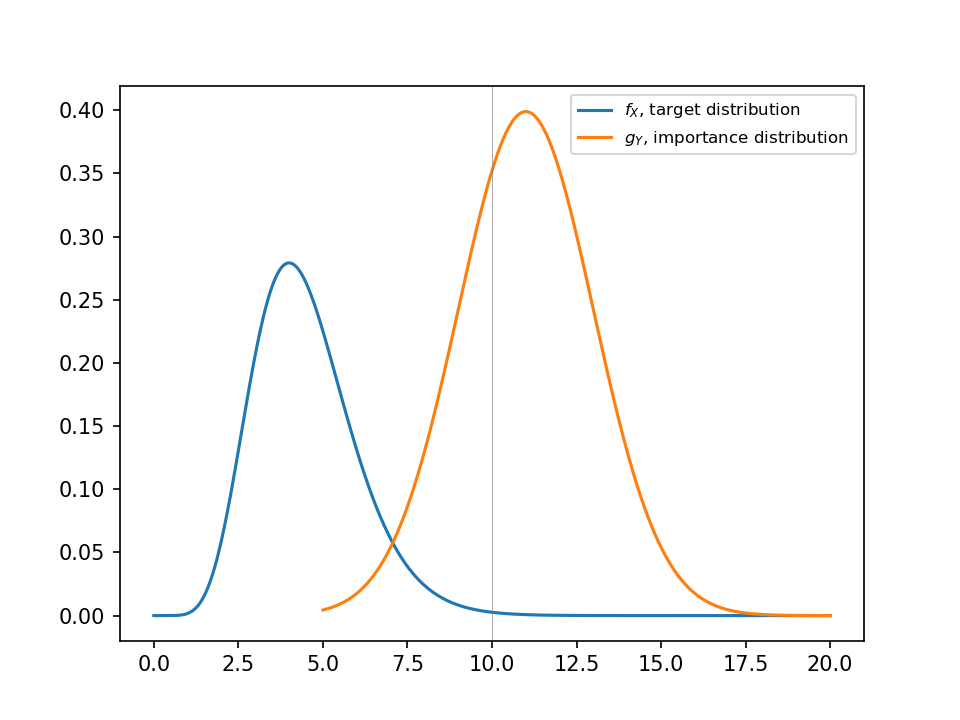

In [58]:
plt.figure()

a = 9
theta = 0.5
plt.plot(np.linspace(0,20,200000), gamma_distribution(np.linspace(0,20,200000), a, theta), label=r"$f_X$, target distribution")

mu = 11
sigma = 1
plt.plot(np.linspace(5,20,200000), normal_distribution(np.linspace(5,20,200000), mu, sigma), label=r"$g_Y$, importance distribution")

plt.legend(fontsize=8)
plt.axvline(x=10, lw=0.3, color="gray")

In [51]:
N = 100000

f = stats.gamma(a=9, scale=.5)
g = stats.norm(loc=11, scale=1)

def h(t):
    if t > 10:
        return 1
    
    else:
        return 0


prob2(f, g, h, N) # True value is 0.00208726

0.0020898065242217503

Checks out!

# Higher dimensions

In [62]:
F = stats.multivariate_normal(mean=np.zeros(2), cov=np.eye(2))
F.pdf([0,0])

0.15915494309189535

In [63]:
F.rvs(size=3) # randomly choose three points

array([[ 0.78281179,  0.50200728],
       [-0.34566193,  0.65011535],
       [ 0.78558228,  0.62392036]])

In [78]:
def prob5(f, g, h, N):
    '''
    Multivariate importance sampling
    Parameters:
        f = target distribution
        g = importance distribution
        h = indicator function
        N = number of random samples to use
    '''
    # Get random samples from the importance distribution
    Y = g.rvs(N)
    
    # Estimate the integral
    P = 0 
    for y_i in Y:
        P += h(y_i) * f.pdf(y_i) / g.pdf(y_i)
        
    return P / N

In [81]:
F = stats.multivariate_normal(mean=np.zeros(2), cov=np.eye(2))
G = stats.multivariate_normal(mean=[1,2], cov=np.eye(2))

def h(t):
    if t.size != 2:
        raise "The vector must be two-dimensional."
    else:
        if (t[0] < -1) and (t[1] > 1):
            return 1

        else:
            return 0
        
prob5(F, G, h, N=1000000) # True value = 0.02517149

0.025357570221777252

Checks out!